# COMP 432 - BIXI


In [12]:
import numpy as np
import pandas as pd
import pickle
import _pickle as cPickle
import bz2
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


def compressed_pickle(title, data):
    with bz2.BZ2File('./data/output/' + title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

hour_trips_dict = decompress_pickle('./data/output/bixi_data_2016_2017_2018.pbz2')
_2019_data = decompress_pickle('./data/output/bixi_data_2019.pbz2')

## Splitting Training Data X(features) and y (targets)

In [120]:
train_group_data = {}

with tqdm(total=len(hour_trips_dict)) as pbar:
    for station_code in hour_trips_dict:
        df = hour_trips_dict[station_code]
        X_train = df[['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
                      'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Month', 'Hour', 'Day_of_year',
                     'Blowing Snow', 'Clear', 'Cloudy',
       'Drizzle', 'Fog', 'Heavy Rain', 'Ice Pellets', 'Mainly Clear',
       'Moderate Rain', 'Moderate Rain Showers', 'Mostly Cloudy', 'Rain',
       'Rain Showers', 'Snow', 'Snow Showers', 'Thunderstorms', 'Haze',
       'Heavy Rain Showers', 'Moderate Drizzle', 'Blowing Dust',
       'Freezing Drizzle', 'Freezing Rain', 'Smoke', 'Snow Grains',
       'Moderate Snow']]
        y_train = df[['hour_trip_count']]

        train_group_data[station_code] = {
            "X_train": X_train,
            "y_train": y_train
        }
        pbar.update(1)


100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:01<00:00, 336.28it/s]


## Splitting Testing Data X and y

In [121]:
from sklearn.model_selection import train_test_split

test_validation_group_data = {}

with tqdm(total=len(_2019_data)) as pbar:
    for station_code in _2019_data:
        df = _2019_data[station_code]
        
        X_tv = df[['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
                      'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Month', 'Hour', 'Day_of_year',
                     'Blowing Snow', 'Clear', 'Cloudy',
       'Drizzle', 'Fog', 'Heavy Rain', 'Ice Pellets', 'Mainly Clear',
       'Moderate Rain', 'Moderate Rain Showers', 'Mostly Cloudy', 'Rain',
       'Rain Showers', 'Snow', 'Snow Showers', 'Thunderstorms', 'Haze',
       'Heavy Rain Showers', 'Moderate Drizzle', 'Blowing Dust',
       'Freezing Drizzle', 'Freezing Rain', 'Smoke', 'Snow Grains',
       'Moderate Snow']]
        y_tv = df[['hour_trip_count']]

        X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=0)
        
        test_validation_group_data[station_code] = {
            "X_test": X_test,
            "y_test": y_test,
            "X_val": X_val,
            "y_val": y_val
        }
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:01<00:00, 272.07it/s]


In [122]:
X_tv.isnull().sum()            #Check if any nullity

Temp (°C)                0
Dew Point Temp (°C)      0
Rel Hum (%)              0
Wind Dir (10s deg)       0
Wind Spd (km/h)          0
Visibility (km)          0
Stn Press (kPa)          0
Month                    0
Hour                     0
Day_of_year              0
Blowing Snow             0
Clear                    0
Cloudy                   0
Drizzle                  0
Fog                      0
Heavy Rain               0
Ice Pellets              0
Mainly Clear             0
Moderate Rain            0
Moderate Rain Showers    0
Mostly Cloudy            0
Rain                     0
Rain Showers             0
Snow                     0
Snow Showers             0
Thunderstorms            0
Haze                     0
Heavy Rain Showers       0
Moderate Drizzle         0
Blowing Dust             0
Freezing Drizzle         0
Freezing Rain            0
Smoke                    0
Snow Grains              0
Moderate Snow            0
dtype: int64

## Training Models

In [150]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from sklearn import linear_model

import sklearn
from sklearn.metrics import mean_absolute_error

In [123]:
train_group_data[5003]['X_train']

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Month,Hour,Day_of_year,...,Thunderstorms,Haze,Heavy Rain Showers,Moderate Drizzle,Blowing Dust,Freezing Drizzle,Freezing Rain,Smoke,Snow Grains,Moderate Snow
0,20.3,-1.4,23.0,20.0,17.0,48.3,102.30,4,14,108,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20.6,-0.5,24.0,19.0,16.0,48.3,102.21,4,15,108,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.9,-1.9,20.0,28.0,20.0,48.3,102.16,4,16,108,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.7,-1.4,21.0,25.0,18.0,48.3,102.12,4,17,108,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.1,-1.0,24.0,25.0,16.0,48.3,102.10,4,18,108,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,2.0,1.6,97.0,4.0,9.0,9.7,100.12,10,11,301,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4779,2.3,1.9,97.0,4.0,10.0,24.1,100.07,10,12,301,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4780,3.1,2.2,93.0,5.0,5.0,16.1,100.04,10,13,301,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4781,3.9,3.0,94.0,36.0,3.0,12.9,100.04,10,14,301,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalize Data

In [133]:
#minmaxx = MinMaxScaler(feature_range=(0,1))
#minmaxy = MinMaxScaler(feature_range=(0,1))

# #  with tqdm(total=len(train_group_data)) as pbar:
#     for key in train_group_data:
#         Data
#         X_train = train_group_data[key]['X_train'].to_numpy()
#         y_train = train_group_data[key]['y_train'].to_numpy()
        
        
#         X_test = test_validation_group_data[key]['X_test'].to_numpy()
#         y_test = test_validation_group_data[key]['y_test'].to_numpy()
        
#         X_val = test_validation_group_data[key]['X_val'].to_numpy()
#         y_val = test_validation_group_data[key]['y_val'].to_numpy()
        
#         #Normalize Data
#         minmaxx.fit(X_test)

#         X_norm = minmaxx.transform(X_train)    #X_train normalized
#         Xtest_norm = minmaxx.transform(X_test)
        
#         minmaxy.fit(y_test.reshape(-1, 1))

#         y_norm = minmaxy.transform(y_train.reshape(-1, 1))   #y_train normalized
#         ytest_norm = minmaxy.transform(y_test.reshape(-1, 1))
        
#         pbar.update(1)
        

100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:02<00:00, 212.68it/s]


In [174]:
train_group_data[key]['X_train'].to_numpy()

array([[ 9.1, -5.2, 36. , ...,  0. ,  0. ,  0. ],
       [10.5, -5.9, 31. , ...,  0. ,  0. ,  0. ],
       [11.4, -5.5, 30. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 3.5,  3. , 97. , ...,  0. ,  0. ,  0. ],
       [ 3.6,  3.2, 97. , ...,  0. ,  0. ,  0. ],
       [ 3.3,  2.8, 97. , ...,  0. ,  0. ,  0. ]])

In [156]:
models_lr = {}
models_lr_train_mse = {}
models_lr_test_mse = {}
models_lr_val_mse = {}

minmaxx = MinMaxScaler(feature_range=(0,1))
minmaxy = MinMaxScaler(feature_range=(0,1))

with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train'].to_numpy()
        y_train = train_group_data[key]['y_train'].to_numpy()
        
        
        X_test = test_validation_group_data[key]['X_test'].to_numpy()
        y_test = test_validation_group_data[key]['y_test'].to_numpy()
        
        X_val = test_validation_group_data[key]['X_val'].to_numpy()
        y_val = test_validation_group_data[key]['y_val'].to_numpy()
        
        #Normalize Data
        #minmaxx.fit(X_test)

        #X_norm = minmaxx.transform(X_train)    #X_train normalized
        #Xtest_norm = minmaxx.transform(X_test)
        
        #minmaxy.fit(y_test.reshape(-1, 1))

        #y_norm = minmaxy.transform(y_train.reshape(-1, 1))   #y_train normalized
        #ytest_norm = minmaxy.transform(y_test.reshape(-1, 1))
        
        # Model
        model = linear_model.Ridge(alpha=1)
        model.fit(X_norm, y_norm)
        models_lr[key] = model
        
        # Training error
        pred = model.predict(X_train)
        models_lr_train_mse[key] = mean_absolute_error(y_train, pred)
        
        # Validation error
        pred = model.predict(X_val)
        models_lr_val_mse[key] = mean_absolute_error(y_val, pred)
        
        # Testing error
        pred = model.predict(X_test)
        models_lr_test_mse[key] = mean_absolute_error(y_test, pred)
        
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 129.18it/s]


In [125]:
X_train

array([[ 9.1, -5.2, 36. , ...,  0. ,  0. ,  0. ],
       [10.5, -5.9, 31. , ...,  0. ,  0. ,  0. ],
       [11.4, -5.5, 30. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 3.5,  3. , 97. , ...,  0. ,  0. ,  0. ],
       [ 3.6,  3.2, 97. , ...,  0. ,  0. ,  0. ],
       [ 3.3,  2.8, 97. , ...,  0. ,  0. ,  0. ]])

## Testing purposes

In [157]:
pd.DataFrame.from_dict(models_lr_train_mse, orient='index').describe()

,0
count,463.000000
mean,4.139348
std,1.252760
min,2.805882
25%,3.244067
50%,3.741750
75%,4.564602
max,12.139865


In [158]:
pd.DataFrame.from_dict(models_lr_test_mse, orient='index').describe()

,0
count,463.000000
mean,4.311018
std,1.311429
min,2.772173
25%,3.350507
50%,3.944347
75%,4.768962
max,11.776115


In [159]:
pd.DataFrame.from_dict(models_lr_val_mse, orient='index').describe()

,0
count,463.000000
mean,4.298709
std,1.316093
min,2.702650
25%,3.338829
50%,3.938827
75%,4.757576
max,11.666941


## Plot prediction using training data

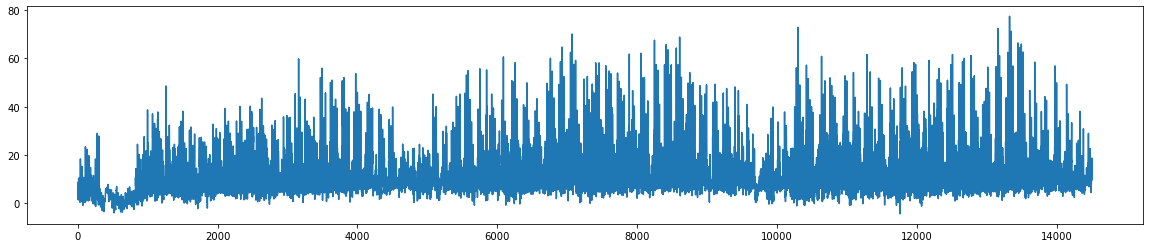

In [166]:
y_pred = models_lr[6100].predict(train_group_data[6100]['X_train'])
y_true = train_group_data[6100]['y_train']
x = np.arange(len(y_pred))
diff = np.subtract(y_true, y_pred)
plt.figure(figsize=(20,4))
plt.plot(x, diff)

## Plot predictions using test_validation data

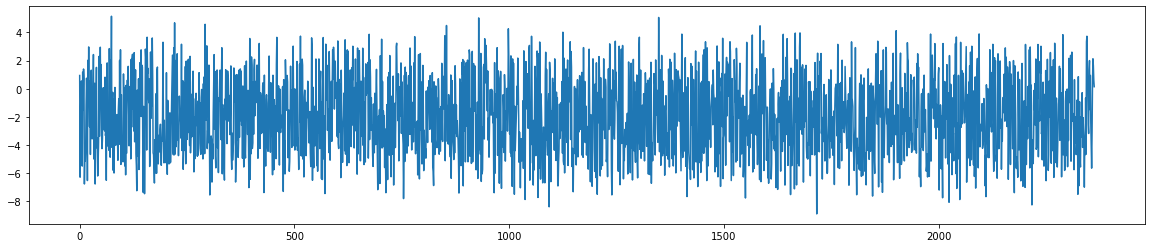

In [161]:
y_pred = models_lr[5003].predict(test_validation_group_data[5003]['X_test'])

y_true = test_validation_group_data[5003]['y_test']
x = np.arange(len(y_pred))
diff = np.subtract(y_pred, y_true)
plt.figure(figsize=(20,4))
plt.plot(x, diff)

## Plot for prediction vs targets

2.861321685161233

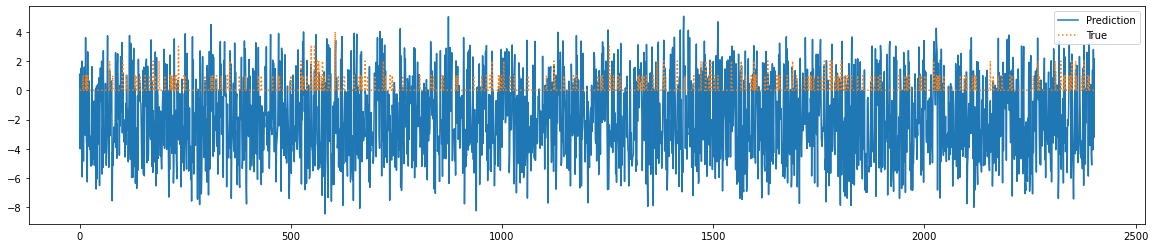

In [172]:
y_pred = models_lr[5004].predict(test_validation_group_data[5004]['X_test'])
y_true = test_validation_group_data[5004]['y_test']
x = np.arange(len(y_pred))

plt.figure(figsize=(20,4))
plt.plot(x, y_pred, label="Prediction")
plt.plot(x, y_true, ':', label="True")
plt.legend()
mean_absolute_error(y_true, y_pred)

6.543968071401901

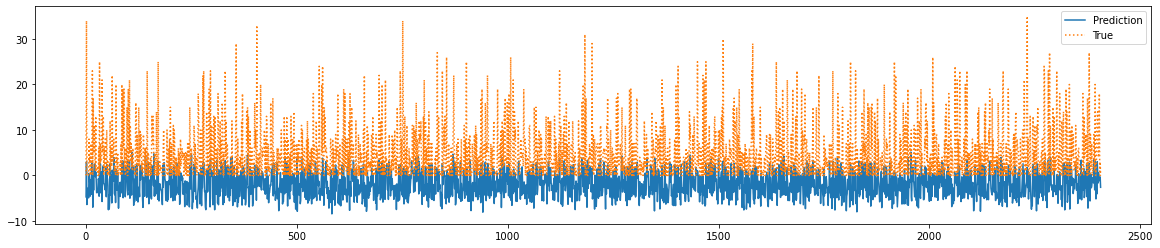

In [164]:
y_pred = models_lr[6080].predict(test_validation_group_data[6080]['X_test'])
y_true = test_validation_group_data[6080]['y_test']
x = np.arange(len(y_pred))

plt.figure(figsize=(20,4))
plt.plot(x, y_pred, label="Prediction")
plt.plot(x, y_true, ':', label="True")
plt.legend()
mean_absolute_error(y_true, y_pred)

In [ ]:
with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
mean_absolute_error(y_true, y_pred)

## Gradient Descent to minimize

In [46]:
models_sgd = {}
models_sgd_train_mse = {}
models_sgd_test_mse = {}
models_sgd_val_mse = {}
with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train']
        y_train = train_group_data[key]['y_train'].to_numpy().flatten()
        
        X_test = test_validation_group_data[key]['X_test']
        y_test = test_validation_group_data[key]['y_test']
        
        X_val = test_validation_group_data[key]['X_val']
        y_val = test_validation_group_data[key]['y_val']
        
        #Normalize data
        flow = make_pipeline(MinMaxScaler(), SGDRegressor())
        
        # Model
        model = flow.fit(X_train, y_train)
        models_sgd[key] = model
        
        # Training error
        pred = model.predict(X_train)
        models_sgd_train_mse[key] = mean_squared_error(y_train, pred)
        
        # Validation error
        pred = model.predict(X_val)
        models_sgd_val_mse[key] = mean_squared_error(y_val, pred)
        
        # Testing error
        pred = model.predict(X_test)
        models_sgd_test_mse[key] = mean_squared_error(y_test, pred)
        
        pbar.update(1)


100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [00:19<00:00, 24.30it/s]


In [47]:
pd.DataFrame.from_dict(models_sgd_train_mse, orient='index').describe()

,0
count,463.000000
mean,6.323395
std,8.336647
min,0.085778
25%,1.691460
50%,3.647813
75%,7.662882
max,69.222116
